# 포트폴리오 구성 전략

어떠한 종목에 투자할 지 선택하는 것도 즁요하지만, 비중을 어떻게 배분하느냐에 따라 성과가 달라지므로 포트폴리오 구성 전략 역시 중요하다. 물론 가장 간편한 형태인 동일비중, 즉 모든 종목에 동일한 비중으로 투자를 할 수도 있다. 그러나 최적의 포트폴리오를 구성한다면 훨씬 안정적인 성과를 거둘 수 있으며, 파이썬에서는 riskfolio-lib 패키지를 이용하면 매우 간단하게 최적 포트폴리오를 구성할 수도 있다.

이번 장에서는 일반적으로 많이 사용되는 최대샤프지수 포트폴리오, 최소분산 포트폴리오, 위험균형 포트폴리오를 구현해보도록 하겠다. 먼저 포트폴리오 구성을 위해 글로벌 자산을 대표하는 ETF 데이터를 다운로드 한 후 DB에 저장한다.

In [24]:
import pandas as pd
import yfinance as yf
import pandas_datareader as web
import pymysql
from sqlalchemy import create_engine

tickers = [
    'SPY',  # 미국 주식
    'IEV',  # 유럽 주식 
    'EWJ',  # 일본 주식
    'EEM',  # 이머징 주식
    'TLT',  # 미국 장기채
    'IEF',  # 미국 중기채
    'IYR',  # 미국 리츠
    'RWX',  # 글로벌 리츠
    'GLD',  # 금
    'DBC'  # 상품
]

all_data = {}
for ticker in tickers:
    #all_data[ticker] = web.DataReader(ticker, 'yahoo', start='1993-01-22')
    all_data[ticker] = yf.download(ticker, start='1993-01-22')

prices = pd.DataFrame(
    {tic: data['Adj Close']
     for tic, data in all_data.items()})

engine = create_engine('mysql+pymysql://root:@127.0.0.1:3306/stock_db')
prices.to_sql(name='sample_etf', con=engine, index=True, if_exists='replace')
engine.dispose()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_47733/1257864962.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prices.to_sql(name='sample_etf', con=connection, index=True, if_exis

AttributeError: 'Connection' object has no attribute 'cursor'

1. 글로벌 대표 자산 ETF의 티커를 입력한다.
2. `DataReader()` 함수를 이용해 야후 파이낸스에서 데이터를 받으며, 기간은 1993년 1월 22일부터 한다.
3. 수정주가에 해당하는 부분만 선택하여 데이터프레임으로 만든다.
4. DB의 sample_etf 테이블에 해당 데이터를 저장한다.

## 수익률 계산 및 상관관계 확인하기

먼저 DB에서 ETF 데이터를 불러온 후 수익률을 계산한다.

In [7]:
price = pd.read_sql('select * from sample_etf;', con = engine)
rets = prices.pct_change(1).dropna()
engine.dispose()

rets.tail().round(4)

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
Date,,,,,,,,,,
2024-06-24,-0.0033,0.0085,0.0076,0.0000,0.0040,0.0008,0.0060,0.0091,0.0040,0.0082
2024-06-25,0.0039,-0.0007,0.0158,-0.0023,0.0017,0.0008,-0.0121,-0.0008,-0.0050,-0.0094
2024-06-26,0.0012,-0.0088,-0.0037,-0.0021,-0.0143,-0.0060,-0.0029,-0.0103,-0.0092,0.0017
2024-06-27,0.0016,-0.0016,0.0051,0.0007,0.0040,0.0022,0.0085,0.0004,0.0113,0.0052
2024-06-28,-0.0039,-0.0016,0.0087,0.0019,-0.0186,-0.0053,0.0077,0.0021,0.0001,-0.0043


1. ETF 데이터를 불러온다.
2. `pct_change()` 함수를 통해 수익률을 계산하며, `dropna()` 함수를 통해 결측치를 제거한다.

이번에는 각 ETF의 수익률 간 상관관계를 살펴보도록 하자.

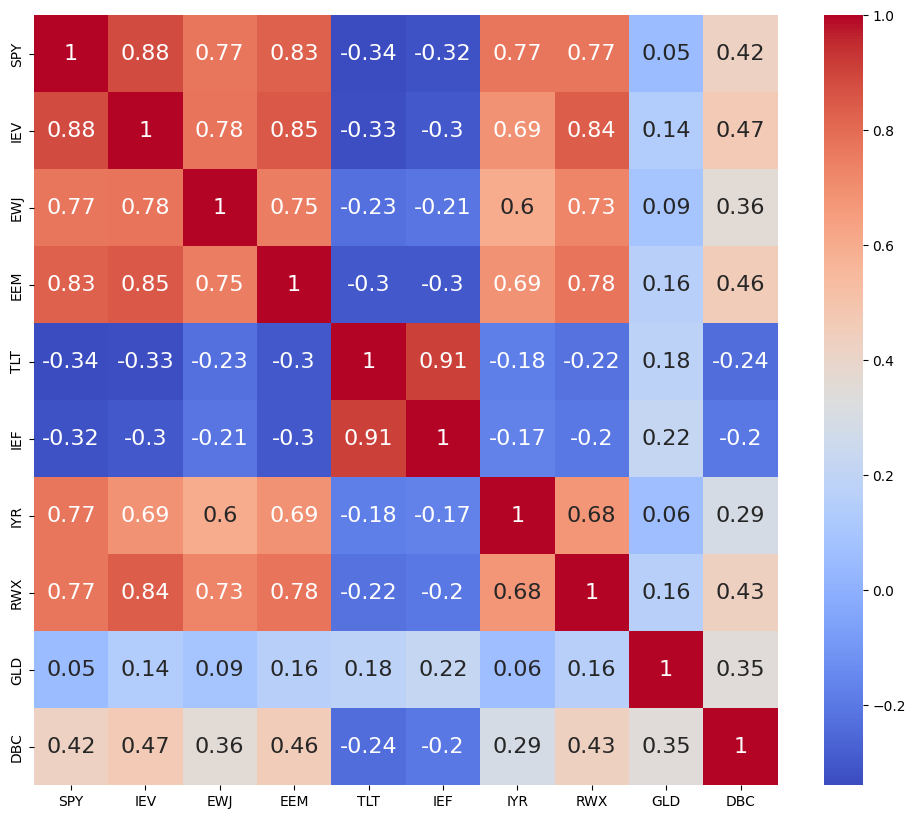

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(rets.corr().round(2), annot = True, annot_kws = {"size" : 16}, cmap='coolwarm')
plt.show()

같은 자산군 내에서는 강한 상관관계를 보이며, 주식과 채권 간에는 매우 낮은 상관관계를 보인다. 또한 주식과 리츠 간에도 꽤 높은 상관관계를 보인다.

## 최대샤프지수 포트폴리오

최대샤프지수 포트폴리오(Maximum Sharpe Ratio Portfolio)란 샤프지수가 최대가 되도록 하는 포트폴리오를 구성하는 것이다. 샤프지수는 $\frac{R_p-R_f}{\sigma_p}$, 즉 포트폴리오의 수익을 변동성으로 나눈 값이며, 위험 대비 수익률이라고도 볼 수 있다. 따라서 샤프지수가 최대가 되는 포트폴리오는 위험은 낮으면서 수익은 높은 지점이다. riskfolio-lib 패키지의 함수를 이용해 해당 포트폴리오를 구성하기 위한 자산별 투자비중을 구해보도록 하자.

In [9]:
import riskfolio as rp

# 포트폴리오 객체 생성
port = rp.Portfolio(returns=rets)

# 입력값 계산
method_mu = 'hist'  # 역사적 데이터를 바탕으로 기대 수익률 추정
method_cov = 'hist'  # 역사적 데이터를 바탕으로 분산-공분산 행렬 추정

# 객체에 수익률 및 분산-공분산 입력
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

model = 'Classic'  # 모델 입력. Classic(역사적 데이터), BL(블랙-리터만), FM(팩터 모형)
rm = 'MV'  # 위험 측정 방법. MV는 표준편차를 의미
obj = 'Sharpe'  # 목적함수. MinRisk(최소분산), MaxRet(최대수익률), Utility(효용) or Sharpe(샤프지수)
hist = True  # 역사적 데이터 사용
rf = 0  # 무위험 수익률
l = 0  # 위험 회피 계수, obj가 'Utility' 일 때만 사용

# 최적화
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

round(w.T, 4)

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
weights,0.2612,0.0,0.0,0.0,0.0,0.6188,0.0,0.0,0.12,0.0


1. `Portfolio()` 함수를 통해 포트폴리오 객체를 생성하며, `returns`에는 수익률 데이터를 입력한다.
2. 'mu(수익률)'과 'cov(분산-공분산 행렬)'을 구한 후 `assets_stats()` 함수에 이를 입력한다.
3. 구하고자 하는 목적에 맞게 각종 파라미터를 입력한다.
4. `optimization()` 함수를 통해 최대샤프지수를 만족하는 포트폴리오의 해를 구한다.

이처럼 패키지를 사용할 경우 최적의 포트폴리오에 대한 수학적 지식이 부족하거나 복잡한 계산을 하지 않고도, 얼마든지 이를 만족하는 해를 구할 수 있다. 이번에는 효율적 투자선을 구성해보도록 하자. 효율적 투자선이란 각 포트폴리오의 기대수익률과 위험 수준을 바탕으로, 구성할 수 있는 모든 포트폴리오를 나타낸 것이다.

In [10]:
points = 50  # 효율적 투자선을 구성하는 샘플 갯수
frontier = port.efficient_frontier(model=model,
                                   rm=rm,
                                   points=points,
                                   rf=rf,
                                   hist=hist)

frontier.T.head().round(4)

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
0,0.1297,0.0,0.0051,0.0,0.0,0.7842,0.0,0.0,0.0000,0.0810
1,0.2093,0.0,0.0000,0.0,0.0,0.7190,0.0,0.0,0.0646,0.0071
2,0.2407,0.0,0.0000,0.0,0.0,0.6615,0.0,0.0,0.0979,0.0000
3,0.2627,0.0,0.0000,0.0,0.0,0.6157,0.0,0.0,0.1216,0.0000
4,0.2811,0.0,0.0000,0.0,0.0,0.5776,0.0,0.0,0.1413,0.0000


1. 몇 개의 점으로 효율적 투자선을 구성할 지 정한다.
2. `efficient_frontier()` 함수를 이용해 효율적 투자선을 이루는 포트폴리오들의 비중을 계산한다.

결과에 나오는 비중들을 통해 효율적 투자선을 구성할 수 있다. 이번엔 그림으로 나타내보도록 하자.

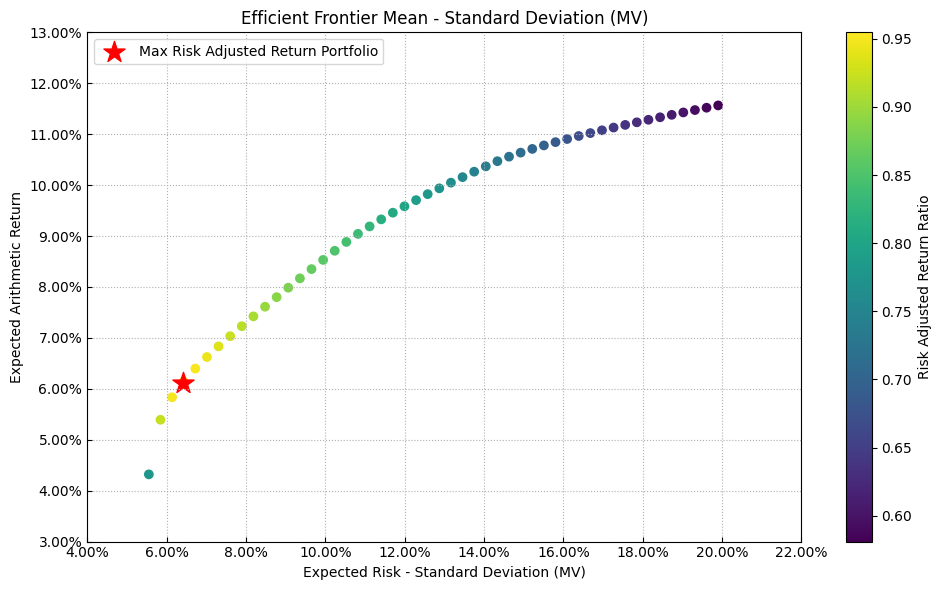

In [11]:
label = 'Max Risk Adjusted Return Portfolio' 
mu = port.mu  # 기대 수익률
cov = port.cov  # 분산-공분산 행렬
returns = port.returns  # 자산 별 수익률

ax = rp.plot_frontier(w_frontier=frontier,
                      mu=mu,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=rf,
                      alpha=0.05,
                      cmap='viridis',
                      w=w,
                      label=label,
                      marker='*',
                      s=16,
                      c='r',
                      height=6,
                      width=10,
                      ax=None)

1. 라벨, 기대 수익률, 분산-공분산 행렬, 자산별 수익률 값을 입력한다.
2. `plot_frontier()` 함수를 통해 효율적 투자선을 시각화한다. 각종 파라미터를 수정하여 그래프를 꾸밀수도 있다.

각 점의 색은 샤프지수를 의미하며, 붉은색 별은 샤프지수가 최대가 되는 점을 의미한다. 

## 최소분산 포트폴리오

효율적 투자선과 무위험 수익률의 접점에 해당하는 최대샤프지수 포트폴리오는 이론적으로 많이 사용되는 포트폴리오 구성 방법이지만, 실무에서는 잘 사용되지 않는다. 그 이유는 크게 다음가 같다.

1. 변동성 및 상관관계는 시간이 지나도 어느정도 유지되는 경향이 있다.
2. 기대 수익률을 추정하는 것은 매우 어렵다. 이론에서는 과거 수익률을 미래 수익률의 예측치로 사용하지만 실제 투자에서 사용하기는 무리가 있는 가정이다.
3. 위 결과를 살펴보면 10개 자산 중 일부 자산으로만 포트폴리오가 구성된다. 즉 상관관계가 높은 자산이 있으면 하나에만 투자하는 결과를 낳는다. 그러나 현실에서는 상관관계가 높은 자산에도 투자해야 하는 경우가 많다.

따라서 실무에서는 1번과 2번의 이유로 인해 기대 수익률에 대한 추정이 필요하지 않은 '최소분산 포트폴리오'를 사용하는 경우가 많으며, 3번의 이유로 인해 각종 제약조건을 추가하기도 한다. '최소분산 포트폴리오(Minimum Variance Portfolio)'는 변동성이 최소인 포트폴리오며, 이 역시 패키지를 이용하면 손쉽게 계산할 수 있다.

In [12]:
import riskfolio as rp

port = rp.Portfolio(returns=rets)
method_mu = 'hist'
method_cov = 'hist'
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

model = 'Classic'
rm = 'MV'
obj = 'MinRisk'  # 목적함수. MinRisk(최소분산), MaxRet(최대수익률), Utility(효용) or Sharpe(샤프지수)
hist = True
rf = 0
l = 0

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

round(w.T, 4)

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
weights,0.1297,0.0,0.0051,0.0,0.0,0.7842,0.0,0.0,0.0,0.081


최대샤프지수 포트폴리오를 계산하는 코드에서 obj 부분만 최소분산에 해당하는 'MinRisk'로 변경하였다. 즉 포트폴리오의 변동성을 최소화 하기 위해서는 각 자산 별로 해당 비중만큼 투자하면 된다. 이번에는 한눈에 확인하기 쉽게 시각화를 해보도록 하자.

/home/denishong/.local/lib/python3.10/site-packages/riskfolio/PlotFunctions.py:765: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


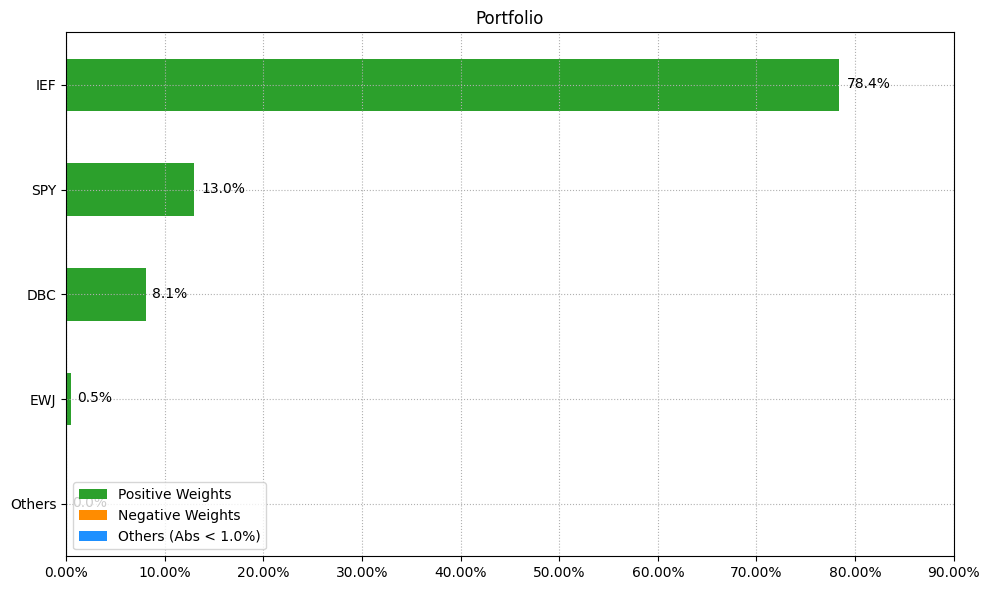

In [14]:
ax = rp.plot_bar(w=w, title='Portfolio',  kind='h', ax=None)

`plot_bar()` 함수를 이용하면 비중을 막대그래프로 나타낼 수 있다. 그림을 살펴보면 채권 ETF가 대부분의 비중을 구성하므로, 이를 이용해 그대로 투자하기는 문제가 있다. 반면 일부 자산은 투자비중이 0%, 즉 전혀 투자하지 않기도 한다. 이처럼 변동성이 가장 낮은 종목에 대부분의 비중이 투자되는 구석해(Corner Solution) 문제를 해결하기 각종 제약조건을 추가해 줄 필요가 있다.

### 최소 및 최대 투자비중 제약조건

모든 자산에 최소 투자비중 5%, 최대 투자비중 20%의 제약조건을 설정하도록 하겠다. 먼저 아래와 같이 유니버스에 해당하는 ETF명과 해당 ETF의 자산군을 데이터프레임 형태로 만든다.

In [15]:
asset_classes = {
    'Asset':
    ['SPY', 'IEV', 'EWJ', 'EEM', 'TLT', 'IEF', 'IYR', 'RWX', 'GLD', 'DBC'],
    'Class': [
        'stock', 'stock', 'stock', 'stock', 'bond', 'bond', 'alternative',
        'alternative', 'alternative', 'alternative'
    ]
}

asset_classes = pd.DataFrame(asset_classes)
asset_classes

,Asset,Class
0,SPY,stock
1,IEV,stock
2,EWJ,stock
3,EEM,stock
4,TLT,bond
5,IEF,bond
6,IYR,alternative
7,RWX,alternative
8,GLD,alternative
9,DBC,alternative


이번에는 제약조건에 해당하는 데이터프레임을 만든다.

In [16]:
constraints = {'Disabled': [False, False],
               'Type': ['All Assets', 'All Assets'],
               'Set': ['', ''],
               'Position': ['', ''],
               'Sign': ['>=', '<='],
               'Weight': [0.05, 0.2],
               'Type Relative': ['', ''],
               'Relative Set': ['', ''],
               'Relative': ['', ''],
               'Factor': ['', '']}

constraints = pd.DataFrame(constraints)
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,>=,0.05,,,,
1,False,All Assets,,,<=,0.20,,,,


1. Disabled: 제약조건의 사용 여부이며, 제약조건 갯수만큼 False를 입력한다.
2. Type: 'All Assets'은 모든 자산(종목)에 적용되는 조건을 의미한다. 각 자산에 조건을 적용할 때는 Assets, 하부 항목에 조건을 적용할 때는 Classes를 입력한다.
3. Set: 위에서 입력한 유니버스 중 제약조건에 해당하는 열을 의미하며, All Assets의 경우 빈칸으로 둔다.
4. Position: 유니버스 중 제약조건에 해당하는 값을 의미하며, All Assets의 경우 빈칸으로 둔다.
5. Sign: 제약조건의 부호를 의미한다.
6. Weight: 제약조건의 값을 의미한다.
7. Type Relative, Relative Set, Relative, Factor: 상대적 제약조건에 해당하며, 빈칸으로 둔다.

총 7가지 제약식에 맞게 입력한 후 데이터프레임 형태로 변경한다. 즉, 개별 투자비중이 5% 이상, 20% 이하인 조건이 만들어졌다. 이제 해당 제약조건을 만족하는 최적의 해를 구해보도록 하자.

In [17]:
A, B = rp.assets_constraints(constraints, asset_classes)

port.ainequality = A
port.binequality = B

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

w.T

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
weights,0.05,0.05,0.05,0.05,0.2,0.2,0.05,0.05,0.192921,0.107079


1. `assets_constraints()` 함수를 통해 제약조건을 행렬 형태로 변경한다. (제약조건은 $Aw \ge B$ 형태로 입력된다.)
2. ainequality와 binequality, 즉 제약조건 부분에 위에서 구한 행렬을 입력한다.
3. `optimization()` 함수를 통해 최소분산 포트폴리오를 만족하는 해를 구한다.

결과를 살펴보면 각 자산에 적어도 5%가 투자되었으며, 최대 비중이 20%를 넘지 않는다. 이로써 구석해 문제가 다소 해결되었다. 비중을 그래프로 나타내보도록 하자.

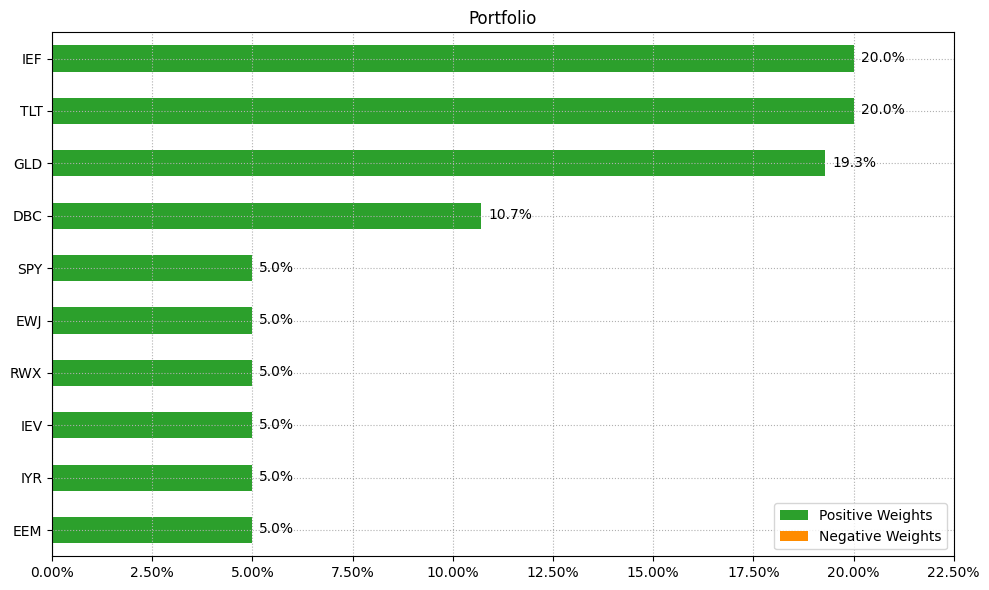

In [18]:
ax = rp.plot_bar(w=w, title='Portfolio',  kind='h', ax=None)

### 각 종목 별 제약조건

위에서 추가한 제약조건만으로도 충분히 훌륭한 포트폴리오가 구성되지만, 투자 규모가 커지면 추가적인 제약조건들을 고려해야 할 경우가 생긴다. 벤치마크 비중과의 괴리로 인한 추적오차(Tracking Error)를 고려해야 할 수도 있고, 투자 대상별 거래량을 고려한 제약조건을 추가해야 할 때도 있다. 

기존 제약조건에는 모든 자산에 동일한 최소 및 최대 투자비중 제약조건을 다루었지만, 자산별로 제약조건을 각각 다르게 설정해야할 때도 있다. 이번에는 {numref}`min_const`과 같이 자산 별로 최소 및 최대 투자비중이 다른 제약조건을 만족하는 포트폴리오를 구성해보도록 하겠다.

```{table} 각 자산 별 최소 및 최대 제약조건
:name: min_const
|제약|SPY|IEV|EWJ|EEM|TLT|IEF|IYR|RWX|GLD|DBC|
|---|---|---|---|---|---|---|---|---|---|---
|최소|0.10|0.10|0.05|0.05|0.10|0.10|0.05|0.05|0.03|0.03|
|최대|0.25|0.25|0.20|0.20|0.20|0.20|0.10|0.10|0.08|0.08|
```

In [19]:
constraints = {
    'Disabled': [
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False
    ],
    'Type': [
        'Assets', 'Assets', 'Assets', 'Assets', 'Assets', 'Assets', 'Assets',
        'Assets', 'Assets', 'Assets', 'Assets', 'Assets', 'Assets', 'Assets',
        'Assets', 'Assets', 'Assets', 'Assets', 'Assets', 'Assets'
    ],
    'Set': [
        'Asset', 'Asset', 'Asset', 'Asset', 'Asset', 'Asset', 'Asset', 'Asset',
        'Asset', 'Asset', 'Asset', 'Asset', 'Asset', 'Asset', 'Asset', 'Asset',
        'Asset', 'Asset', 'Asset', 'Asset'
    ],
    'Position': [
        'SPY', 'IEV', 'EWJ', 'EEM', 'TLT', 'IEF', 'IYR', 'RWX', 'GLD', 'DBC',
        'SPY', 'IEV', 'EWJ', 'EEM', 'TLT', 'IEF', 'IYR', 'RWX', 'GLD', 'DBC'
    ],
    'Sign': [
        '>=', '>=', '>=', '>=', '>=', '>=', '>=', '>=', '>=', '>=', '<=', '<=',
        '<=', '<=', '<=', '<=', '<=', '<=', '<=', '<='
    ],
    'Weight': [
        0.10, 0.10, 0.05, 0.05, 0.10, 0.10, 0.05, 0.05, 0.03, 0.03, 0.25, 0.25,
        0.20, 0.20, 0.20, 0.20, 0.10, 0.10, 0.08, 0.08
    ],
    'Type Relative': [
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', ''
    ],
    'Relative Set': [
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', ''
    ],
    'Relative': [
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', ''
    ],
    'Factor': [
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', ''
    ]
}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,Assets,Asset,SPY,>=,0.10,,,,
1,False,Assets,Asset,IEV,>=,0.10,,,,
2,False,Assets,Asset,EWJ,>=,0.05,,,,
3,False,Assets,Asset,EEM,>=,0.05,,,,
4,False,Assets,Asset,TLT,>=,0.10,,,,
5,False,Assets,Asset,IEF,>=,0.10,,,,
6,False,Assets,Asset,IYR,>=,0.05,,,,
7,False,Assets,Asset,RWX,>=,0.05,,,,
8,False,Assets,Asset,GLD,>=,0.03,,,,
9,False,Assets,Asset,DBC,>=,0.03,,,,


1. Disabled: 제약조건이 총 20개이므로 False를 20번 입력한다.
2. Type: 제약조건을 각 자산에 적용하므로 Assets를 입력한다.
3. Set: 유니버스 중 티커에 해당하는 Asset을 입력한다.
4. Position: 유니버스 중 티커명을 입력한다.
5. Sign: 제약조건의 부호를 의미한다.
6. Weight: 제약조건의 값을 의미한다.
7. Type Relative, Relative Set, Relative, Factor: 상대적 제약조건에 해당하며, 빈칸으로 둔다.

각 종목(티커) 별 최소 및 최대 투자비중을 각기 다르게 입력했다. 이를 만족하는 포트폴리오를 계산해보도록 한다.

In [20]:
A, B = rp.assets_constraints(constraints, asset_classes)

port.ainequality = A
port.binequality = B

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

w.T

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
weights,0.1,0.1,0.09,0.05,0.2,0.2,0.05,0.05,0.08,0.08


결과를 살펴보면 {numref}`min_const`에서 설정한 최소 및 최대 투자비중의 범위 내에 해가 위치함을 확인할 수 있다.

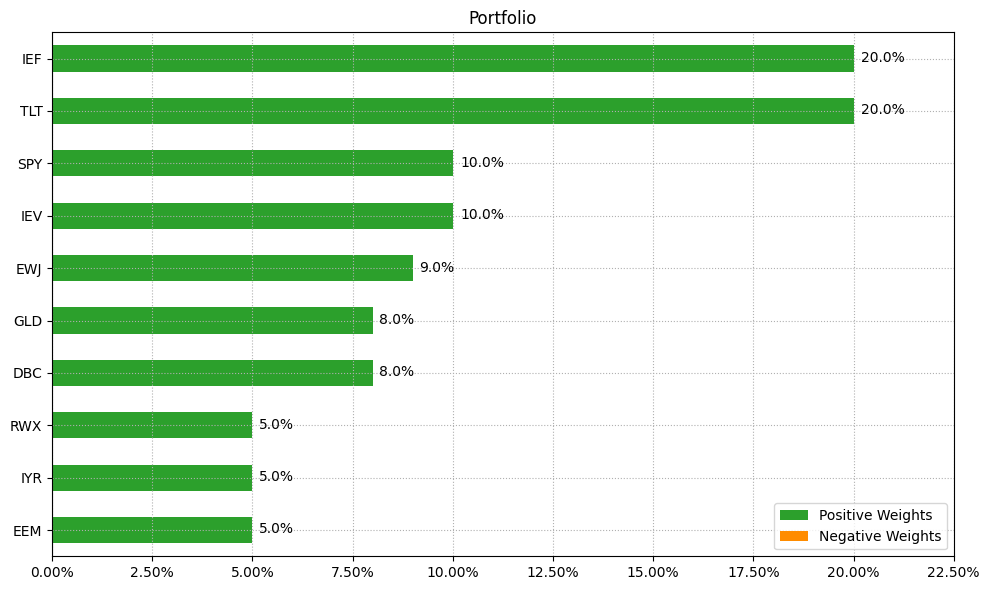

In [21]:
ax = rp.plot_bar(w=w, title='Portfolio',  kind='h', ax=None)

### 자산군 별 비중

마지막으로 개별 자산이 아닌 자산군 별로 제약조건을 다르게 주도록 한다. 즉 {numref}`min_const_2`와 같이 주식 ETF에 투자하는 비중은 최소 40%, 최대 70%이어야 한다. 또한 자산군 내에서 한 종목에 투자 비중이 쏠리는 것을 방지하기 위해 개별 자산의 투자 비중은 최소 3%, 최대 20%로 한다.

```{table} 각 자산 별 최소 및 최대 제약조건
:name: min_const_2
|제약|개별|주식|채권|대체자산|
|---|---|---|---|---|
|최소|0.03|0.4|0.3|0.1| 
|최대|0.20|0.7|0.5|0.2|
```

In [22]:
constraints = {
    'Disabled': [False, False, False, False, False, False, False, False],
    'Type': [
        'All Assets', 'All Assets', 'Classes', 'Classes', 'Classes', 'Classes',
        'Classes', 'Classes'
    ],
    'Set': ['', '', 'Class', 'Class', 'Class', 'Class', 'Class', 'Class'],
    'Position':
    ['', '', 'stock', 'bond', 'alternative', 'stock', 'bond', 'alternative'],
    'Sign': ['>=', '<=', '>=', '>=', '>=', '<=', '<=', '<='],
    'Weight': [0.03, 0.20, 0.40, 0.30, 0.10, 0.70, 0.50, 0.20],
    'Type Relative': ['', '', '', '', '', '', '', ''],
    'Relative Set': ['', '', '', '', '', '', '', ''],
    'Relative': ['', '', '', '', '', '', '', ''],
    'Factor': ['', '', '', '', '', '', '', '']
}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,>=,0.03,,,,
1,False,All Assets,,,<=,0.20,,,,
2,False,Classes,Class,stock,>=,0.40,,,,
3,False,Classes,Class,bond,>=,0.30,,,,
4,False,Classes,Class,alternative,>=,0.10,,,,
5,False,Classes,Class,stock,<=,0.70,,,,
6,False,Classes,Class,bond,<=,0.50,,,,
7,False,Classes,Class,alternative,<=,0.20,,,,


1. Disabled: 개별 자산의 제약 조건 2개, 자산군 별 제약 조건이 6개 이므로 False를 8개 입력한다.
2. Type: 모든 자산(종목)에 적용되는 조건은 'All Assets'을, 자산군에 적용되는 조건은 'Classes'를 입력한다.
3. Set: 모든 자산(종목)에 적용되는 조건에는 공백을, 자산군에 적용되는 조건은 열 이름인 'Class'를 입력한다.
4. Position: 공백 및 자산군을 입력한다.
5. Sign: 제약조건의 부호를 의미한다.
6. Weight: 제약조건의 값을 의미한다.
7. Type Relative, Relative Set, Relative, Factor: 상대적 제약조건에 해당하며, 빈칸으로 둔다.

In [23]:
A, B = rp.assets_constraints(constraints, asset_classes)

port.ainequality = A
port.binequality = B

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

w.T

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
weights,0.2,0.03,0.14,0.03,0.2,0.2,0.03,0.03,0.11,0.03


위 제약조건을 만족하는 해를 구하였다. 자산군 별 제약조건이 제대로 적용되었는지 확인해보도록 하자.

In [24]:
w_concat = pd.concat([asset_classes.set_index('Asset'), w], axis=1)
w_concat.groupby(['Class']).sum().sort_values(['weights'], ascending=False)

,weights
Class,
stock,0.4
bond,0.4
alternative,0.2


자산군 별 그룹을 묶어 비중을 더해보면 {numref}`min_const_2`에서 설정한 최소 및 최대 투자비중의 범위 내에 해가 위치함을 확인할 수 있다. 이처럼 패키지 내의 함수를 이용하면 복잡한 제약조건도 매우 손쉽게 적용할 수 있다.

## 위험균형 포트폴리오

포트폴리오를 구성하는 자산들과 전체 위험의 관계를 이해하기 위해서는, 먼저 한계 위험기여도(MRC: Marginal Risk Contribution)와 위험기여도(RC: Risk Contribution)에 대해 알아야 한다. 한계 위험기여도는 특정 자산의 비중을 한 단위 증가시켰을 때 전체 포트폴리오 위험의 증가를 나타내는 단위로서, 수학의 편미분과 같은 개념이다. $i$번째 자산의 한계 위험기여도는 아래와 같이 나타낼 수 있다.

$$MRC_i = \frac{\partial\sigma_p}{\partial w_i} $$

$\sqrt {f'(x)} = \frac{f'(x)}{2\sqrt{f(x)}}$인 사실을 이용하면, 한계 위험기여도는 다음과 같이 풀 수 있다. 결과적으로 분자는 분산-공분산 행렬과 각 자산의 비중의 곱, 분모는 포트폴리오의 표준편차 형태로 나타난다.

$$
\begin{equation} 
\begin{split}
\frac{\partial\sigma_p}{\partial w} & = \frac{\partial(\sqrt{w'\Omega w})}{\partial w} \\
& =\frac{\partial(w'\Omega w)}{\partial w} \times \frac{1}{2\sqrt{w'\Omega w}} \\
& =\frac{2\Omega w}{2\sqrt{w'\Omega w}} \\
& =\frac{\Omega w}{\sqrt{w'\Omega w}}
\end{split}
\end{equation} 
$$

위험기여도는 특정 자산이 포트폴리오 내에서 차지하는 위험의 비중이다. 한계 위험기여도가 큰 자산도 포트폴리오 내에서 비중이 작다면, 포트폴리오 내에서 차지하는 위험의 비중은 작을 것이다. 반면에, 한계 위험기여도가 작은 자산일지라도 비중이 압도적으로 많다면, 포트폴리오 내에서 차지하는 위험의 비중은 클 것이다. 결과적으로 $i$번째 자산의 위험기여도는, $i$번째 자산의 한계 위험기여도와 포트폴리오 내 비중의 곱으로 이루어진다.

$$RC_i = \frac{\partial\sigma_p}{\partial w_i} \times w_i$$

특정 자산이 포트폴리오의 위험을 대부분 차지하는 문제를 막고, 모든 자산이 동일한 위험기여도를 가지는 포트폴리오가 위험균형 포트폴리오(Risk Parity Portfolio) 혹은 동일 위험기여도 포트폴리오(Equal Risk Contribution Portfolio)다. 이를 수식으로 쓰면 다음과 같습니다.

$$RC_1 = RC_2 = \dots = RC_n$$
$$\frac{\partial\sigma_p}{\partial w_1} \times w_1 = \frac{\partial\sigma_p}{\partial w_2} \times w_2
= \dots = \frac{\partial\sigma_p}{\partial w_n} \times w_n = \frac{1}{n}$$

다행인 점은 위험균형 포트폴리오를 구하기 위해 위의 수식을 알 필요가 없다는 점이다. riskfolio-lib 패키지의 함수를 이용하면 이 역시 손쉽게 계산할 수 있다.

In [25]:
import riskfolio as rp

port = rp.Portfolio(returns=rets)
method_mu = 'hist'
method_cov = 'hist'
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

model = 'Classic'
rm = 'MV'
hist = True
rf = 0
b = None  # 위험기여도 제약조건

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

w_rp.T

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
weights,0.063782,0.051034,0.061783,0.042309,0.167741,0.333311,0.043982,0.054944,0.096628,0.084487


최대샤프지수 및 최소분산 포트폴리오와 거의 비슷하게 값을 입력하며, `obj` 대신 위험기여도 제약조건에 해당하는 `b` 인자를 입력한다. `rp_optimization()` 함수를 이용하면 위험균형 포트폴리오를 만족하는 해가 계산된다. 해당 비중으로 포트폴리오를 구성하면 모든 자산이 동일한 위험기여도를 가지는지 확인해보도록 하자.

In [1]:
ax = rp.plot_risk_con(w_rp,
                      cov=port.cov,
                      returns=port.returns,
                      rm=rm,
                      rf=0,
                      alpha=0.01,
                      color="tab:blue",
                      height=6,
                      width=10,
                      ax=None)

NameError: name 'rp' is not defined

`plot_risk_con()` 함수를 이용하면 투자 비중에 따른 자산들의 위험기여도를 알 수 있으며, 모든 자산이 동일한 위험기여도를 가진다는 것이 확인된다.

### 위험예산 포트폴리오

모든 자산의 위험기여도가 동일한 값이 아닌, 자산별로 다른 위험기여도를 가지는 포트폴리오를 구성해야 할 경우도 있다. 이러한 포트폴리오를 위험예산 포트폴리오(Risk Budget Portfolio)라고 한다. 위험균형 포트폴리오는 각 자산의 위험예산이 $\frac{1}{n}$로 동일한 특수 형태이다.

먼저 각 자산 별 위험예산을 {numref}`risk_contri`과 같이 정한다. 즉, 1\~4번 자산(주식)은 각각 15%씩, 5\~6번 자산(채권)은 각각 10%씩, 7\~10번 자산(대체자산)은 각각 5%씩 위험예산을 부여한다.

```{table} 위험예산 포트폴리오 예시
:name: risk_contri
|제약|SPY|IEV|EWJ|EEM|TLT|IEF|IYR|RWX|GLD|DBC|
|---|---|---|---|---|---|---|---|---|---|---
|예산|0.15|0.15|0.15|0.15|0.10|0.10|0.05|0.05|0.05|0.05|
```

In [27]:
b = [0.15, 0.15, 0.15, 0.15, 0.10, 0.10, 0.05, 0.05, 0.05, 0.05]
w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

w_rp.T

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
weights,0.090343,0.073329,0.086366,0.060732,0.176092,0.354211,0.022084,0.02741,0.060123,0.049309


위험균형 포트폴리오를 구하는 코드에서, 위험기여도에 해당하는 b 부분만 변경한다. 즉, 해당 부분에 위험예산을 입력한다. 해당 비중으로 포트폴리오를 구성하면 우리가 원한 위험예산 포트폴리오를 만족하는 확인해보도록 한다.

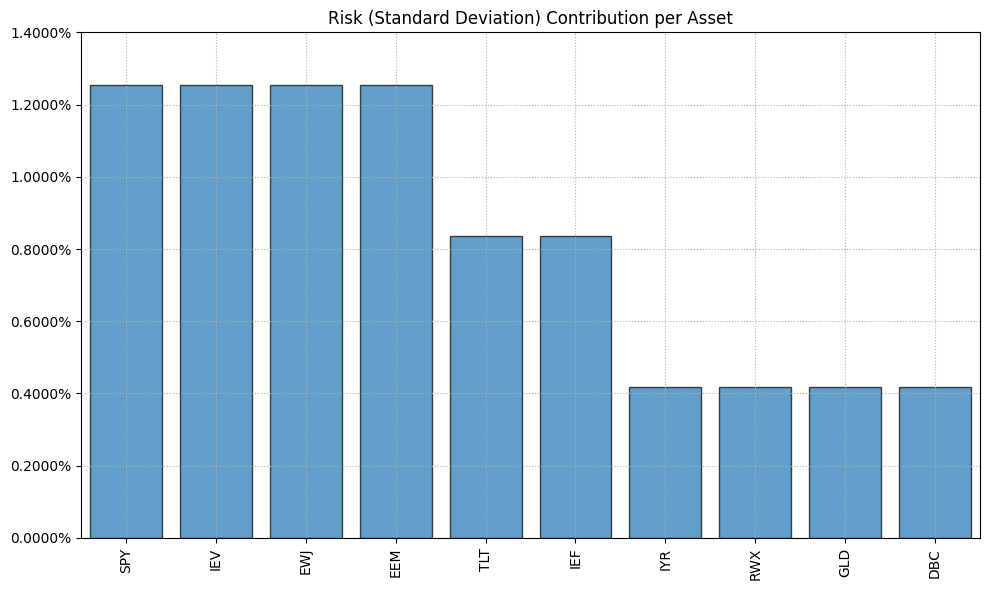

In [28]:
ax = rp.plot_risk_con(w_rp,
                      cov=port.cov,
                      returns=port.returns,
                      rm=rm,
                      rf=0,
                      alpha=0.01,
                      color="tab:blue",
                      height=6,
                      width=10,
                      ax=None)

각 자산의 위험기여도가 {numref}`risk_contri`에서 설정한 목표치와 동일함이 확인된다.

```{note}
이 외에도 Riskfolio 패키지의 자세한 사용법은 공식 홈페이지를 참조하기 바란다.

https://riskfolio-lib.readthedocs.io/en/latest/index.html
```